# **Extracting our Datasets**

In [1]:
from google.colab import drive
drive.mount('/content/drive')
# this allows us to access files stored in our Google Drive and use them within our colab notebook

Mounted at /content/drive


In [2]:
!apt install unzip
# install the unzip utility, which allows us to extract contents from zip files

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [3]:
!unzip -q "/content/drive/MyDrive/Animals.zip"
# unzip the file "Animals.zip" into the current directory in Colab environment

In [4]:
!unzip -q "/content/drive/MyDrive/Emotions.Final.zip"
# unzip the file "Emotions.Final.zip" into the current directory in Colab environment

# **Preprocessing for Animals dataset**

Import needed libraries

In [5]:
import cv2                                               # (opencv) computer vision library used for various image and video processing tasks
import os                                                # provides a way to interact with the os, allowing functionalities such as file handling and directory manipulation
import numpy as np                                       # used for numerical computations (handling arrays and matrices in image processing tasks)
from tqdm import tqdm                                    # provides a progress bar for loops or tasks
import zipfile                                           # provides tools to create, read, write, and extract zip archives
import random                                            # allows generating random numbers, selecting random elements
from google.colab.patches import cv2_imshow              # function that enables displaying images using OpenCV within a Google Colab notebook
from keras.preprocessing.image import ImageDataGenerator # creates augmented batches of images for training deep learning models

Extract contents from a ZIP file into a specified folder

In [6]:
# define the paths
input_zip_path = "/content/drive/MyDrive/Animals.zip" # path to the ZIP file containing images of animals
extracted_folder_path = "/content/extracted_images"   # destination path where the contents of the ZIP file will be extracted
resized_folder_path = "/content/resized_images"       # path where the resized images will be stored
augmented_folder_path = "/content/augmented_images"   # path where augmented images will be saved

# function to extract the ZIP file
def extract_zip(zip_path, extract_to): # takes 2 parameters(the path to the ZIP file, the path where the contents will be extracted)
    try:
        # zipfile.ZipFile --> extract the contents of the ZIP file to the specified "extract_to" folder
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        # if successful, it returns True
        return True
    # otherwise, it prints an error message and returns False
    except Exception as e:
        print(f"Error extracting ZIP file: {e}")
        return False

# call the previous function to check for extraction success
if extract_zip(input_zip_path, extracted_folder_path):
    print("Extraction successful.")
else:
    print("Extraction failed. Please check the ZIP file.")

Extraction successful.


Resize images using OpenCV and Normalize their pixel values

In [7]:
# function that will resize and normalize images
def resize_and_normalize(input_folder, output_folder, target_size=(224, 224)):
    # creates the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # iterates through each category in the input folder
    for category in os.listdir(input_folder):
        category_path = os.path.join(input_folder, category)
        output_category_path = os.path.join(output_folder, category)
        os.makedirs(output_category_path, exist_ok=True)

        # process images by looping through each image file in the category folder
        for filename in tqdm(os.listdir(category_path), desc=f"Processing {category}"):
            # constructs the path to the current image
            image_path = os.path.join(category_path, filename)
            # constructs the path for the resized and normalized image in the output folder
            output_path = os.path.join(output_category_path, filename)
            # read and resize image to the specified target_size using OpenCV
            img = cv2.imread(image_path)
            img = cv2.resize(img, target_size)
            # normalize pixel values to be between 0 and 1 by dividing by 255
            img = img / 255.0
            # saves the resized and normalized image to the output folder
            cv2.imwrite(output_path, img)

# calls the previous function by passing extracted_folder_path (where images are extracted) and the resized_folder_path (where resized and normalized images will be saved)
resize_and_normalize(extracted_folder_path, resized_folder_path)

Processing Cats: 100%|██████████| 50/50 [00:00<00:00, 68.59it/s]


Image augmentation using Keras 'ImageDataGenerator'

In [8]:
# Function for image augmentation using ImageDataGenerator
def augment_images_with_generator(input_folder, output_folder, num_augmentations=5):
    # creates the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # creates an ImageDataGenerator object (datagen) with desired augmentation configurations
    datagen = ImageDataGenerator(
        # randomly flips images horizontally
        horizontal_flip=True,
        # randomly rotates the images within a range of 20 degrees
        rotation_range=20,
        # randomly shifts the width of the images by 20% of the total width
        width_shift_range=0.2,
        # randomly shifts the height of the images by 20% of the total height
        height_shift_range=0.2,
        # applies shear transformation to the images (alter the shape of images by pushing or stretching them in a specified direction)
        shear_range=0.2,
        # randomly images can be zoomed in or out by a factor of up to 20%
        zoom_range=0.2,
        # fills in newly created pixels after transformations (new pixels will be filled with values from the nearest existing pixel)
        fill_mode='nearest'
    )

    for category in os.listdir(input_folder): # iterates through each category in the input folder
        category_path = os.path.join(input_folder, category)
        output_category_path = os.path.join(output_folder, category)
        os.makedirs(output_category_path, exist_ok=True)

        for filename in os.listdir(category_path): # loops through each image file in the category folder
            # constructs the path to the current image
            image_path = os.path.join(category_path, filename)
            # reads the original image using OpenCV
            original_image = cv2.imread(image_path)
            # reshape the image to (1, height, width, channels) for ImageDataGenerator
            img_array = original_image.reshape((1,) + original_image.shape)
            # generate augmented images
            i = 0
            '''batch in datagen.flow --> generate batches of augmented images from the img_array
               saves the augmented images to the output folder for the respective category
               prefixes the saved images with 'aug_' followed by the original image's filename.
               save_format='jpg' --> specifies the image format for saving'''
            for batch in datagen.flow(img_array, batch_size=1, save_to_dir=output_category_path, save_prefix=f"aug_{filename.split('.')[0]}", save_format='jpg'):
                i += 1
                if i >= num_augmentations:
                    break  # breaks the loop after generating the specified number of augmentations

# calls the previous function by passing resized_folder_path, augmented_folder_path (to save the augmented images), and specifies generating 5 augmented versions for each image
augment_images_with_generator(resized_folder_path, augmented_folder_path, num_augmentations=5)



Retrieve and display the contents of resized, and augmented directories

In [9]:
# os.listdir --> retrieves a list of filenames in the directory

# list contents of the resized images directory
resized_contents = os.listdir(resized_folder_path)
print("Resized Images Directory Contents:", resized_contents)

# list contents of the augmented images directory
augmented_contents = os.listdir(augmented_folder_path)
print("Augmented Images Directory Contents:", augmented_contents)

Resized Images Directory Contents: ['Dogs', 'Cats']
Augmented Images Directory Contents: ['Dogs', 'Cats']


Read and Display random augmented image

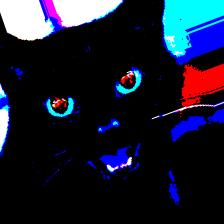

In [10]:
# specify the path to the augmented images directory
augmented_folder_path = "/content/augmented_images"

# list all files in the augmented images directory
all_augmented_images = []
for category in os.listdir(augmented_folder_path):
    category_path = os.path.join(augmented_folder_path, category)
    all_augmented_images.extend([os.path.join(category_path, filename) for filename in os.listdir(category_path)])

# select one random augmented image path
random_augmented_image_path = random.choice(all_augmented_images)

# read and display the chosen augmented image from the generated path
random_augmented_image = cv2.imread(random_augmented_image_path)
cv2_imshow(random_augmented_image)

# **Splitting data into training, validation, and testing sets**

Import extra needed libraries

In [11]:
import shutil                                        # provides functions for file operations, such as copying, moving, and deleting files or directories
from sklearn.model_selection import train_test_split # splits datasets into random train and test subsets

In [12]:
# define paths for the augmented 'cats' and 'dogs' images within the augmented folder
augmented_cats_path = os.path.join(augmented_folder_path, 'cats')
augmented_dogs_path = os.path.join(augmented_folder_path, 'dogs')

# paths for the directories where the training, validation, and testing sets will be stored
train_path = '/content/train'
val_path = '/content/validation'
test_path = '/content/test'

# create directories for training, validation, and testing sets
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# function that takes the input augmented images, performs the splitting, and copies images to appropriate directories based on the specified ratios (val_size and test_size).
def split_data(input_folder, train_folder, val_folder, test_folder, val_size=0.2, test_size=0.1):
    categories = os.listdir(input_folder)

    for category in categories: # iterates through categories ('cats' and 'dogs') in the augmented images folder
        category_path = os.path.join(input_folder, category)
        # for each category: splits images into training, validation, and testing sets using train_test_split() twice to achieve the desired split ratios
        train_category_path = os.path.join(train_folder, category)
        val_category_path = os.path.join(val_folder, category)
        test_category_path = os.path.join(test_folder, category)
        # creates paths for the training, validation, and testing categories for each specific category ('cats' or 'dogs')
        os.makedirs(train_category_path, exist_ok=True)
        os.makedirs(val_category_path, exist_ok=True)
        os.makedirs(test_category_path, exist_ok=True)
        # retrieves a list of filenames within the category directory
        images = os.listdir(category_path)
        # divides the images into train_images and test_images based on the provided ratio (test_size=(val_size + test_size))
        train_images, test_images = train_test_split(images, test_size=(val_size + test_size), random_state=42)
        # divides the test_images into val_images and test_images again based on the ratio (test_size/(val_size + test_size))
        val_images, test_images = train_test_split(test_images, test_size=test_size/(val_size + test_size), random_state=42)

        # for each category: copies images from the original categories to the appropriate split directories ('train', 'validation', 'test') based on the obtained splits
        for image in train_images:
            shutil.copy(os.path.join(category_path, image), os.path.join(train_category_path, image))

        for image in val_images:
            shutil.copy(os.path.join(category_path, image), os.path.join(val_category_path, image))

        for image in test_images:
            shutil.copy(os.path.join(category_path, image), os.path.join(test_category_path, image))

# calls the previous function with paths and sizes for splitting the data into training, validation, and testing sets
split_data(augmented_folder_path, train_path, val_path, test_path)

# **Preprocessing for Emotions dataset**

Import extra needed libraries

In [13]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img

Extract contents from a ZIP file into a specified folder

In [14]:
# define the paths
input_zip_path = "/content/drive/MyDrive/Emotions.zip" # path to the ZIP file containing images of Emotions
extracted_folder_path = "/content/extracted_images"   # destination path where the contents of the ZIP file will be extracted
resized_folder_path = "/content/resized_images"       # path where the resized images will be stored
augmented_folder_path = "/content/augmented_images"   # path where augmented images will be saved

# function to extract the ZIP file
def extract_zip(zip_path, extract_to): # takes 2 parameters(the path to the ZIP file, the path where the contents will be extracted)
    try:
        # zipfile.ZipFile --> extract the contents of the ZIP file to the specified "extract_to" folder
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        # if successful, it returns True
        return True
    # otherwise, it prints an error message and returns False
    except Exception as e:
        print(f"Error extracting ZIP file: {e}")
        return False

# call the previous function to check for extraction success
if extract_zip(input_zip_path, extracted_folder_path):
    print("Extraction successful.")
else:
    print("Extraction failed. Please check the ZIP file.")

Extraction successful.


Resize images using OpenCV and Normalize their pixel values

In [15]:
# function that will resize and normalize images
def resize_and_normalize(input_folder, output_folder, target_size=(224, 224)):
    # creates the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # iterates through each category in the input folder
    for category in os.listdir(input_folder):
        category_path = os.path.join(input_folder, category)
        output_category_path = os.path.join(output_folder, category)
        os.makedirs(output_category_path, exist_ok=True)

        # check if the category path is a directory
        if os.path.isdir(category_path):
            # process images by looping through each image file in the category folder
            for filename in tqdm(os.listdir(category_path), desc=f"Processing {category}"):
               # constructs the path to the current image
               image_path = os.path.join(category_path, filename)
               # constructs the path for the resized and normalized image in the output folder
               output_path = os.path.join(output_category_path, filename)
               # read image using OpenCV
               img = cv2.imread(image_path)
               if img is None:
                    print(f"Error loading image: {image_path}")
                    continue
               # resize image using cv2.INTER_AREA interpolation
               img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
               # normalize pixel values to be between 0 and 1 by dividing by 255
               img = img / 255.0
               # saves the resized and normalized image to the output folder
               cv2.imwrite(output_path, img)

# calls the previous function by passing extracted_folder_path (where images are extracted) and the resized_folder_path (where resized and normalized images will be saved)
resize_and_normalize(extracted_folder_path, resized_folder_path)

Processing Cats: 100%|██████████| 50/50 [00:00<00:00, 73.41it/s]


Image augmentation using Keras 'ImageDataGenerator'

In [16]:
# Function for image augmentation using ImageDataGenerator
def augment_images_with_generator(input_folder, output_folder, num_augmentations=5):
    # creates the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # creates an ImageDataGenerator object (datagen) with desired augmentation configurations
    datagen = ImageDataGenerator(
        # randomly flips images horizontally
        horizontal_flip=True,
        # randomly rotates the images within a range of 20 degrees
        rotation_range=20,
        # randomly shifts the width of the images by 20% of the total width
        width_shift_range=0.2,
        # randomly shifts the height of the images by 20% of the total height
        height_shift_range=0.2,
        # applies shear transformation to the images (alter the shape of images by pushing or stretching them in a specified direction)
        shear_range=0.2,
        # randomly images can be zoomed in or out by a factor of up to 20%
        zoom_range=0.2,
        # fills in newly created pixels after transformations (new pixels will be filled with values from the nearest existing pixel)
        fill_mode='nearest'
    )

    for category in os.listdir(input_folder): # iterates through each category in the input folder
        category_path = os.path.join(input_folder, category)
        output_category_path = os.path.join(output_folder, category)
        os.makedirs(output_category_path, exist_ok=True)

        for filename in os.listdir(category_path): # loops through each image file in the category folder
            # constructs the path to the current image
            image_path = os.path.join(category_path, filename)
            # reads the original image using OpenCV
            original_image = cv2.imread(image_path)
            # reshape the image to (1, height, width, channels) for ImageDataGenerator
            img_array = original_image.reshape((1,) + original_image.shape)
            # generate augmented images
            i = 0
            '''batch in datagen.flow --> generate batches of augmented images from the img_array
               saves the augmented images to the output folder for the respective category
               prefixes the saved images with 'aug_' followed by the original image's filename.
               save_format='jpg' --> specifies the image format for saving'''
            for batch in datagen.flow(img_array, batch_size=1, save_to_dir=output_category_path, save_prefix=f"aug_{filename.split('.')[0]}", save_format='jpg'):
                i += 1
                if i >= num_augmentations:
                    break  # breaks the loop after generating the specified number of augmentations

# calls the previous function by passing resized_folder_path, augmented_folder_path (to save the augmented images), and specifies generating 5 augmented versions for each image
augment_images_with_generator(resized_folder_path, augmented_folder_path, num_augmentations=5)

# **Splitting data into training, validation, and testing sets**

In [17]:
# define paths for the augmented 'happy' and 'sad' images within the augmented folder
augmented_cats_path = os.path.join(augmented_folder_path, 'happy')
augmented_dogs_path = os.path.join(augmented_folder_path, 'sad')

# paths for the directories where the training, validation, and testing sets will be stored
train_path = '/content/train'
val_path = '/content/validation'
test_path = '/content/test'

# create directories for training, validation, and testing sets
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# function that takes the input augmented images, performs the splitting, and copies images to appropriate directories based on the specified ratios (val_size and test_size).
def split_data(input_folder, train_folder, val_folder, test_folder, val_size=0.2, test_size=0.1):
    categories = os.listdir(input_folder)

    for category in categories: # iterates through categories ('happy' and 'sad') in the augmented images folder
        category_path = os.path.join(input_folder, category)
        # for each category: splits images into training, validation, and testing sets using train_test_split() twice to achieve the desired split ratios
        train_category_path = os.path.join(train_folder, category)
        val_category_path = os.path.join(val_folder, category)
        test_category_path = os.path.join(test_folder, category)
        # creates paths for the training, validation, and testing categories for each specific category ('happy' or 'sad')
        os.makedirs(train_category_path, exist_ok=True)
        os.makedirs(val_category_path, exist_ok=True)
        os.makedirs(test_category_path, exist_ok=True)
        # retrieves a list of filenames within the category directory
        images = os.listdir(category_path)
        # divides the images into train_images and test_images based on the provided ratio (test_size=(val_size + test_size))
        train_images, test_images = train_test_split(images, test_size=(val_size + test_size), random_state=42)
        # divides the test_images into val_images and test_images again based on the ratio (test_size/(val_size + test_size))
        val_images, test_images = train_test_split(test_images, test_size=test_size/(val_size + test_size), random_state=42)

        # for each category: copies images from the original categories to the appropriate split directories ('train', 'validation', 'test') based on the obtained splits
        for image in train_images:
            shutil.copy(os.path.join(category_path, image), os.path.join(train_category_path, image))

        for image in val_images:
            shutil.copy(os.path.join(category_path, image), os.path.join(val_category_path, image))

        for image in test_images:
            shutil.copy(os.path.join(category_path, image), os.path.join(test_category_path, image))

# calls the previous function with paths and sizes for splitting the data into training, validation, and testing sets
split_data(augmented_folder_path, train_path, val_path, test_path)

## **Building the Model**

Import extra needed libraries

In [18]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout # imports specific layers from the Keras library
from tensorflow.keras.optimizers import Adam                             # optimization algorithm used to update network weights iteratively based on training data
from tensorflow.keras.models import Model                                # create neural network models by specifying inputs and outputs
from tensorflow.keras.callbacks import ModelCheckpoint                   # saves the model's weights at certain intervals during training
from tensorflow.keras.utils import to_categorical                        # converts class vectors to binary class matrices (one-hot encoded) for categorical classification tasks

Create custom data generator

In [19]:
# Image dimensions and other parameters
img_width, img_height = 224, 224 # defines the width and height for input images
input_shape = (img_width, img_height, 3) # defines the input shape for the neural network model
epochs = 5 # indicates the number of training epochs

# specifies the path to the combined "train" folder containing the training data for both animal species and emotion recognition
train_path = "/content/train"

'''creates a custom data generator that fetches data from the specified directory, and defines two generators:
One for animal species with classes 'Cats' and 'Dogs', another for emotion with classes 'Happy' and 'Sad'''
def custom_data_generator(directory, batch_size, target_size, class_mode_animal, class_mode_emotion):
    datagen = ImageDataGenerator(rescale=1./255)

    generator_animal = datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode_animal,
        classes=['Cats', 'Dogs']
    )

    generator_emotion = datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode_emotion,
        classes=['Happy', 'Sad']
    )
    # the function yields batches of data for both tasks as a tuple ([X_animal, X_emotion], {'animal_species_output': y_animal, 'emotion_output': y_emotion}).
         # (provide both animal species and emotion recognition outputs)
    while True:
        X_animal, y_animal = generator_animal.next()
        X_emotion, y_emotion = generator_emotion.next()

        # Print the batch shapes for debugging
        print(f'Animal batch shape: {X_animal.shape} {y_animal.shape}')
        print(f'Emotion batch shape: {X_emotion.shape} {y_emotion.shape}')

        # Yield both animal species and emotion outputs as a tuple
        yield ([X_animal, X_emotion], {'animal_species_output': y_animal, 'emotion_output': y_emotion})

# Number of classes for animal species and emotion recognition
num_animal_species_classes = 2  # cats and dogs
num_emotion_classes = 2  # happy and sad

In [20]:
directory = "/content/train"
batch_size = 32
target_size = (224, 224)
class_mode_animal = 'categorical'
class_mode_emotion = 'categorical'

# Create the generator
data_gen = custom_data_generator(
    directory,
    batch_size=batch_size,
    target_size=target_size,
    class_mode_animal=class_mode_animal,
    class_mode_emotion=class_mode_emotion
)

# Get a batch from the generator
batch = next(data_gen)

Found 814 images belonging to 2 classes.
Found 348 images belonging to 2 classes.
Animal batch shape: (32, 224, 224, 3) (32, 2)
Emotion batch shape: (32, 224, 224, 3) (32, 2)


Build the model

In [21]:
# Shared convolutional base
input_layer_animal = Input(shape=input_shape)
input_layer_emotion = Input(shape=input_shape)

conv1 = Conv2D(32, (3, 3), activation='relu') # Conv2D: Represents a 2D convolutional layer used for spatial convolution over images
pool1 = MaxPooling2D(pool_size=(2, 2))        # MaxPooling2D: a layer that performs max pooling operation to reduce the spatial dimensions of the input volume
conv2 = Conv2D(64, (3, 3), activation='relu')
pool2 = MaxPooling2D(pool_size=(2, 2))
conv3 = Conv2D(128, (3, 3), activation='relu')
pool3 = MaxPooling2D(pool_size=(2, 2))
flatten = Flatten()   # reshapes the input data into a 1D array, used to transition from convolutional layers to dense layers

# Animal species recognition head
dense1_animal = Dense(512, activation='relu') # Dense: a standard fully connected neural network layer
dropout1_animal = Dropout(0.5)                # Dropout: a regularization technique that randomly sets input units to 0 with 0.5 prob during training to prevent overfitting
output_animal = Dense(num_animal_species_classes, activation='softmax', name='animal_species_output')

# Emotion recognition head
dense1_emotion = Dense(512, activation='relu')
dropout1_emotion = Dropout(0.5)
output_emotion = Dense(num_emotion_classes, activation='softmax', name='emotion_output')

# Connect layers to the input layers
animal_features = flatten(pool3(conv3(pool2(conv2(pool1(conv1(input_layer_animal)))))))
emotion_features = flatten(pool3(conv3(pool2(conv2(pool1(conv1(input_layer_emotion)))))))

dense1_animal = dense1_animal(animal_features)
dropout1_animal = dropout1_animal(dense1_animal)
output_animal = output_animal(dropout1_animal)

dense1_emotion = dense1_emotion(emotion_features)
dropout1_emotion = dropout1_emotion(dense1_emotion)
output_emotion = output_emotion(dropout1_emotion)

Model compilation

In [22]:
 #Create the model
model = Model(inputs=[input_layer_animal, input_layer_emotion], outputs=[output_animal, output_emotion])

# Adjust the learning rate in the Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss={'animal_species_output': 'categorical_crossentropy', 'emotion_output': 'categorical_crossentropy'},
              metrics={'animal_species_output': 'accuracy', 'emotion_output': 'accuracy'})

Define generators

In [23]:
# Calculate total number of samples for steps_per_epoch
num_samples = sum([len(files) for _, _, files in os.walk(train_path)])
steps_per_epoch = num_samples // batch_size

# Print information for debugging
print("Total Number of Samples:", num_samples)
print("Steps per Epoch:", steps_per_epoch)

batch_size = 32

# Create the data generator
train_generator = custom_data_generator(
    train_path,
    batch_size=batch_size,
    target_size=(img_width, img_height),
    class_mode_animal='categorical',
    class_mode_emotion='categorical'
)

# Create the data generators for validation and test sets
val_generator = custom_data_generator(
    val_path,
    batch_size=batch_size,
    target_size=(img_width, img_height),
    class_mode_animal='categorical',
    class_mode_emotion='categorical'
)

test_generator = custom_data_generator(
    test_path,
    batch_size=batch_size,
    target_size=(img_width, img_height),
    class_mode_animal='categorical',
    class_mode_emotion='categorical'
)


Total Number of Samples: 1162
Steps per Epoch: 36


Train the model

In [24]:
# Get the number of samples in your dataset
num_samples = sum([len(files) for _, _, files in os.walk(train_path)])

# Calculate steps per epoch
steps_per_epoch = num_samples // batch_size

# Train the model and collect history
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    verbose=1
)

Found 814 images belonging to 2 classes.
Found 348 images belonging to 2 classes.
Animal batch shape: (32, 224, 224, 3) (32, 2)
Emotion batch shape: (32, 224, 224, 3) (32, 2)
Epoch 1/5
Animal batch shape: (32, 224, 224, 3) (32, 2)
Emotion batch shape: (32, 224, 224, 3) (32, 2)
Animal batch shape: (32, 224, 224, 3) (32, 2)
Emotion batch shape: (32, 224, 224, 3) (32, 2)
 1/36 [..............................] - ETA: 8:31 - loss: 1.3551 - animal_species_output_loss: 0.6679 - emotion_output_loss: 0.6872 - animal_species_output_accuracy: 0.5312 - emotion_output_accuracy: 0.5625Animal batch shape: (32, 224, 224, 3) (32, 2)
Emotion batch shape: (32, 224, 224, 3) (32, 2)
 2/36 [>.............................] - ETA: 5:05 - loss: 1.4185 - animal_species_output_loss: 0.6594 - emotion_output_loss: 0.7591 - animal_species_output_accuracy: 0.5625 - emotion_output_accuracy: 0.5938Animal batch shape: (32, 224, 224, 3) (32, 2)
Emotion batch shape: (32, 224, 224, 3) (32, 2)
 3/36 [=>....................

In [25]:
# Print the accuracies
print("Animal Species Accuracy:", history.history['animal_species_output_accuracy'])
print("Emotion Accuracy:", history.history['emotion_output_accuracy'])

Animal Species Accuracy: [0.5925925970077515, 0.6966490149497986, 0.7849462628364563, 0.8880070447921753, 0.9312169551849365]
Emotion Accuracy: [0.5666666626930237, 0.7657894492149353, 0.8999999761581421, 0.9357394576072693, 0.980701744556427]


In [26]:
# Save the model
model.save("/path/to/your/model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
from keras.models import load_model

# Load the trained model
loaded_model = load_model("/path/to/your/model.h5")

Test the model

In [32]:
from keras.preprocessing import image

1/1 [==============================] - 0s 167ms/step
Predicted Animal Species: Dog
Predicted Emotion: Sad


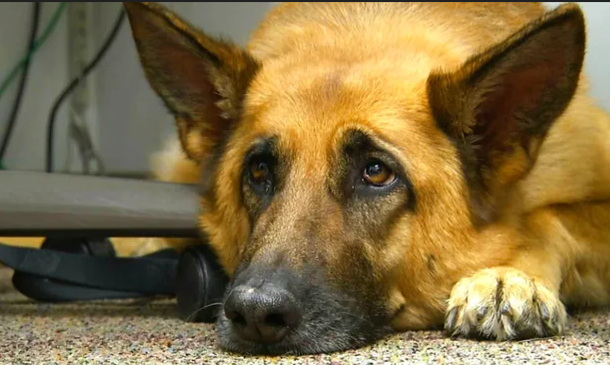

In [34]:
# Function to preprocess the input image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale to [0, 1]
    return img_array

# Function to predict emotions and animal species
def predict_image(model, image_path):
    # Preprocess the input image
    img_array = preprocess_image(image_path)

    # Make predictions
    predictions = model.predict([img_array, img_array])

    # Get the class indices for animal species and emotion
    animal_species_class_index = np.argmax(predictions[0])
    emotion_class_index = np.argmax(predictions[1])

    # Map the class indices to class labels
    animal_species_labels = {0: 'Cat', 1: 'Dog'}
    emotion_labels = {0: 'Happy', 1: 'Sad'}

    # Get the predicted labels
    predicted_animal_species = animal_species_labels[animal_species_class_index]
    predicted_emotion = emotion_labels[emotion_class_index]

    # Print the predictions
    print(f"Predicted Animal Species: {predicted_animal_species}")
    print(f"Predicted Emotion: {predicted_emotion}")

    # Display the image
    img = cv2.imread(image_path)
    cv2_imshow(img)

# Example usage
image_path = '/content/sad8.png'  # Replace with the actual path to your test image
predict_image(model, image_path)

Testing the code on live camera

In [41]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


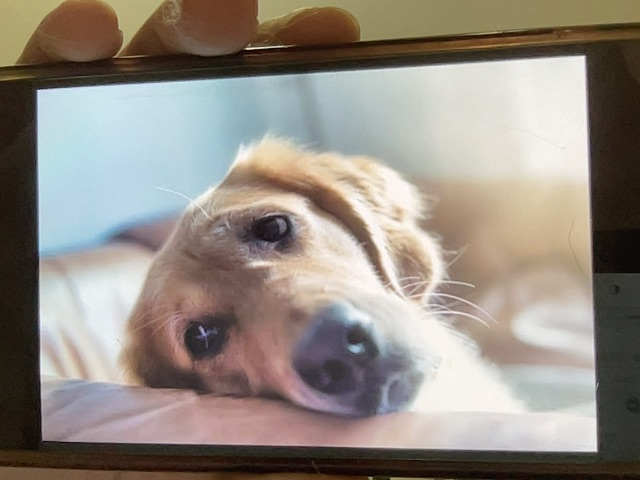

In [53]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

Failed to capture frame. Exiting.


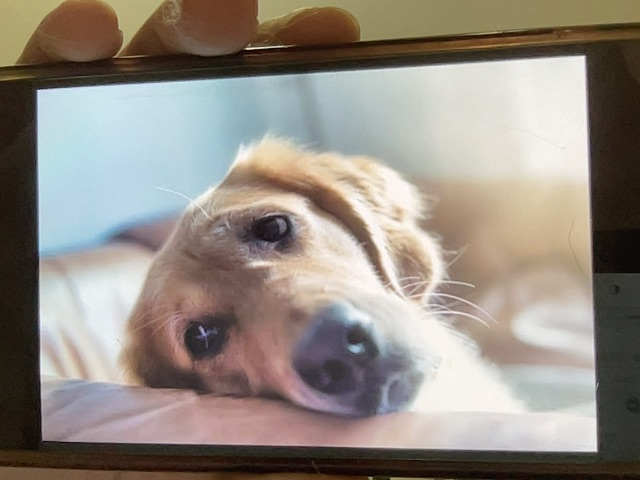

1/1 [==============================] - 0s 259ms/step
Predicted Animal Species: Dog
Predicted Emotion: Happy


In [54]:
import cv2
import numpy as np
from keras.models import load_model
from tensorflow.keras.preprocessing import image
from google.colab.patches import cv2_imshow

# Load the trained model
model = load_model("/path/to/your/model.h5")  # Replace with your model path

# Define function to preprocess the input image
def preprocess_image(img):
    img = cv2.resize(img, (224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale to [0, 1]
    return img_array

# Function to capture an image from the camera and classify it
def capture_and_classify():
    cap = cv2.VideoCapture(0)  # Access the default camera (0)
    while True:
        ret, frame = cap.read()  # Capture frame-by-frame
        if not ret:
            print("Failed to capture frame. Exiting.")
            break

        cv2_imshow(frame)  # Display the frame using cv2_imshow
        if cv2.waitKey(1) & 0xFF == ord('c'):  # Press 'c' to capture the image
            cv2.imwrite('captured_image.jpg', frame)  # Save the captured image
            break
    cap.release()  # Release the camera
    cv2.destroyAllWindows()  # Close all OpenCV windows

    # Path to the captured image
    captured_image_path = '/content/photo.jpg'

    # Read the captured image
    captured_img = cv2.imread(captured_image_path)
    if captured_img is not None:
        cv2_imshow(captured_img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

        # Preprocess the captured image
        processed_img = preprocess_image(captured_img)

        # Make predictions
        predictions = model.predict([processed_img, processed_img])

        # Get the class indices for animal species and emotion
        animal_species_class_index = np.argmax(predictions[0])
        emotion_class_index = np.argmax(predictions[1])

        # Map the class indices to class labels
        animal_species_labels = {0: 'Cat', 1: 'Dog'}
        emotion_labels = {0: 'Happy', 1: 'Sad'}

        # Get the predicted labels
        predicted_animal_species = animal_species_labels[animal_species_class_index]
        predicted_emotion = emotion_labels[emotion_class_index]

        # Print the predictions
        print(f"Predicted Animal Species: {predicted_animal_species}")
        print(f"Predicted Emotion: {predicted_emotion}")
    else:
        print("Failed to read captured image. Please check the image path.")

# Call the function to capture an image and classify it
capture_and_classify()
